# Training notebook for MMCNP

Data used here are for demonstration purposes and not reported in anywhere else.

First: init your environnment

Since our objective is generating joints from hand movement, validation will contain executing generated joints in environment

In [1]:
import torch
from environment import Environment
env = Environment(gui = 0)
def get_angle(traj):
    env.reset()
    pos_pred = env.use_joint_series(traj)
    pos_pred = torch.tensor(pos_pred)
    ds = pos_pred[-5:].mean(dim = 0) - pos_pred[:5].mean(dim = 0)
    k = torch.arctan(torch.tensor(ds[2] / ds[1]))/torch.pi * 180 
    return k.item() , pos_pred 

2023-09-14 15:27:27.278751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 15:27:27.320727: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
pybullet build time: May  2 2023 06:00:32
EGL device choice: -1 of 3.


argv[0]=
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 4090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 535.86.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 535.86.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 4090/PCIe/SSE2
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_footprintb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base/link_tipb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examp

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import data
import models
import copy

In [3]:
# Adjust model parameters

MAX_ITER = 500000
LR = 0.0001
BATCH_SIZE = 1
MAX_CONTEXT = 5
MAX_TARGET = 5
IN_SHAPE = (1, 5)
HIDDEN_SIZE = 64
NUM_HIDDEN_LAYERS = 2
MIN_STD = 0.01
LATENT_DIM = 8

In [4]:
# load your training and validation data
# If you dont have data files, you can set synthetic to true
# this will simulate a human moving in perfect line
# and a robot whose joints generate sinus curves during actions

synthetic = False
trainset = data.JointLandmarkDataset("data/ver5/joints.pt", "data/ver5/landmarks.pt", synthetic=synthetic)
valset = data.JointLandmarkDataset("data/ver5_val/joints.pt", "data/ver5_val/landmarks.pt", synthetic=synthetic, phase=3.14/ 12)

In [5]:
# Initialize model and optimizer
# optimizer is initialized in another cell, because I want to be able to init optimizer after loading a model
model = models.MMCNP(hidden_size=HIDDEN_SIZE,
                   num_hidden_layers=NUM_HIDDEN_LAYERS, min_std=MIN_STD, latent_dim=LATENT_DIM)
model_cp = None

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

In [7]:
print(f"Num Model parameters: {sum(p.numel() for p in model.parameters())}")

Num Model parameters: 20574


The training loop is bellow.

Model should train in moderately quickly.

During training, stop once in a while and check model's performance using visualization bellow.

There is no simple way to compare trajectories as worse trajectories can result in better losses.

So, good old manual labor comes handy.

In [8]:
avg_loss = 0.0
avg_val_loss = 0.0
best_val_loss = 300
# std training loop
for it in range(MAX_ITER):
    # sample data
    context, target, context_mask, target_mask = trainset.get_sample(batch_size=BATCH_SIZE,
                                                                     max_context=MAX_CONTEXT,
                                                                     max_target=MAX_TARGET)
    # compute loss
    loss = model.nll_loss(observation=context,
                          target=(target[0][..., [0]],target[1][..., [0]]),  # 0 contains timestep which is our query dimension
                          target_truth=(target[0][..., 1:],target[1][..., 1:]),
                          observation_mask=context_mask,
                          target_mask=target_mask)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
    if (it+1) % 1000 == 0:
        for i in range(200):
            with torch.no_grad():
                context, target, context_mask, target_mask = valset.get_sample(batch_size=BATCH_SIZE,
                                                                        max_context=MAX_CONTEXT,
                                                                        max_target=MAX_TARGET)
        # compute loss
                val_loss = model.nll_loss(observation=context,
                                    target=(target[0][..., [0]],target[1][..., [0]]),  # 0 contains timestep which is our query dimension
                                    target_truth=(target[0][..., 1:],target[1][..., 1:]),
                                    observation_mask=context_mask,
                                    target_mask=target_mask)
                avg_val_loss += val_loss.item()
        error = 0
        # execute predicted trajectories in environment
        # check the offset between trajectory data and executed trajectories

        # to check the offset, we used angles between initial and final positions
        # in future, a smarter way to compare curves is required
        if synthetic:
            continue
        for act in range(valset.joint.shape[0]):
            obs_joints = valset.joint[act:act+1 , [10,15,20,25, 29], :]  # only the first timestep is observed
            obs_landmarks = valset.landmark[act:act+1 , [10,15,20,25, 29], :] 
            target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
            target_landmarks = valset.landmark[[act], :, :1]
            obs = (None, obs_landmarks)
            target = (target_joints, target_landmarks)
            with torch.no_grad():
                mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )
            pred , pred_pos= get_angle(mean[0])
            org, org_pos = get_angle(valset.joint[act, :, 1:])
            error += (pred - org) ** 2 / valset.joint.shape[0]
            # print(f"action{act}: actual angle = {org}, pred_angle = {pred}")
        if avg_val_loss < best_val_loss:
            model_cp = copy.deepcopy(model)
            best_val_loss = avg_val_loss
        print(f"iter={it}, loss={avg_loss / 1000}, val_loss= {avg_val_loss/200}, error= {error}")
        avg_loss = 0
        avg_val_loss = 0
        avg_loss = 0 

/tmp/ipykernel_17145/1411699826.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.arctan(torch.tensor(ds[2] / ds[1]))/torch.pi * 180


iter=999, loss=1.153878175586462, val_loss= 0.6860453271865845, error= 994.7598664367646
iter=1999, loss=0.30634203597903253, val_loss= 0.1986009830981493, error= 420.86639153136446
iter=2999, loss=-0.0825405665487051, val_loss= -0.17612156383693217, error= 12.823011671778518
iter=3999, loss=-0.5818556238720194, val_loss= -0.17703408170491458, error= 12.552568767408175
iter=4999, loss=-1.0044398104250432, val_loss= 0.17723452299833298, error= 59.20549826379471
iter=5999, loss=-1.2456460293233396, val_loss= 0.7135386345535517, error= 27.03852068656828
iter=6999, loss=-1.420867280855775, val_loss= 1.1485488256812095, error= 98.62831740269704
iter=7999, loss=-1.637413334466517, val_loss= 0.3379298795387149, error= 74.86668436056725
iter=8999, loss=-1.8781148332208395, val_loss= 0.5218221551924944, error= 46.4826339724177
iter=9999, loss=-2.1239580340236426, val_loss= 0.4837513028085232, error= 29.148333923244344
iter=10999, loss=-2.4026626458466054, val_loss= 2.135519247800112, error= 27.

In [ ]:
model = model_cp

In [ ]:
#use this if you want to a save a checkpoint
# torch.save(model_cp, "model6_sub.pt")

In [ ]:
#use this if you want to go back to a saved checkpoint
# model = torch.load("model31.pt")

The code bellow generate trajectories using landmark data.

Generated trajectories and trajectories from landmark dataset will be executed in simulation.

Angles between first and last position will be outputted, if trained correctly, the error should be in 6 - 9 degree range

In [ ]:
avg_val_loss = 0
model.eval()
for i in range(200):
            with torch.no_grad():
                context, target, context_mask, target_mask = valset.get_sample(batch_size=BATCH_SIZE,
                                                                        max_context=MAX_CONTEXT,
                                                                        max_target=MAX_TARGET)
        # compute loss
                val_loss = model.nll_loss(observation=context,
                                    target=(target[0][..., [0]],target[1][..., [0]]),  # 0 contains timestep which is our query dimension
                                    target_truth=(target[0][..., 1:],target[1][..., 1:]),
                                    observation_mask=context_mask,
                                    target_mask=target_mask)
                avg_val_loss += val_loss.item()
print(f"current val loss: {avg_val_loss / 200}")
for act in range(valset.joint.shape[0]):
            obs_joints = valset.joint[act:act+1 , [10,15,20,25,29], :]  # only the first timestep is observed
            obs_landmarks = valset.landmark[act:act+1 , [10,15,20,25,29], :] 
            target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
            target_landmarks = valset.landmark[[act], :, :1]
            obs = (None, obs_landmarks)
            target = (target_joints, target_landmarks)
            with torch.no_grad():
                mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )
            pred , pred_pos= get_angle(mean[0])
            org, org_pos = get_angle(valset.joint[act, :, 1:])
            print(f"action{act}: actual angle = {org}, pred_angle = {pred}")

current val loss: -2.376568777859211
action0: actual angle = 18.232885104139807, pred_angle = 13.056484352087947
action1: actual angle = 50.801579030954045, pred_angle = 54.61256344753705
action2: actual angle = 78.28060792869552, pred_angle = 77.48616613293456


/tmp/ipykernel_15374/1411699826.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.arctan(torch.tensor(ds[2] / ds[1]))/torch.pi * 180


action3: actual angle = -74.58828614317974, pred_angle = -73.46611220646045
action4: actual angle = -44.37944525228702, pred_angle = -32.922407733591506
action5: actual angle = -11.500981771654677, pred_angle = -14.325544585637708
action6: actual angle = 22.144978090537787, pred_angle = 6.89895385356587


Code bellow demonstrates prediction and actual data.

Predictions are generated using hand movement.

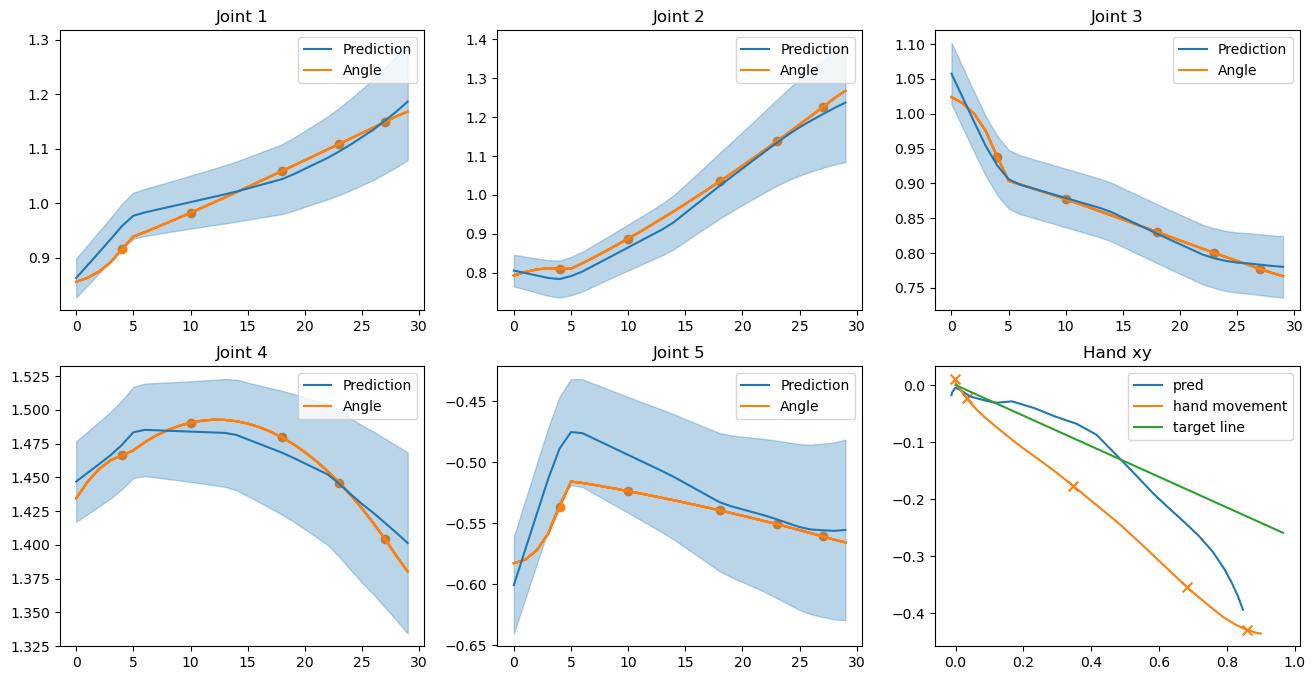

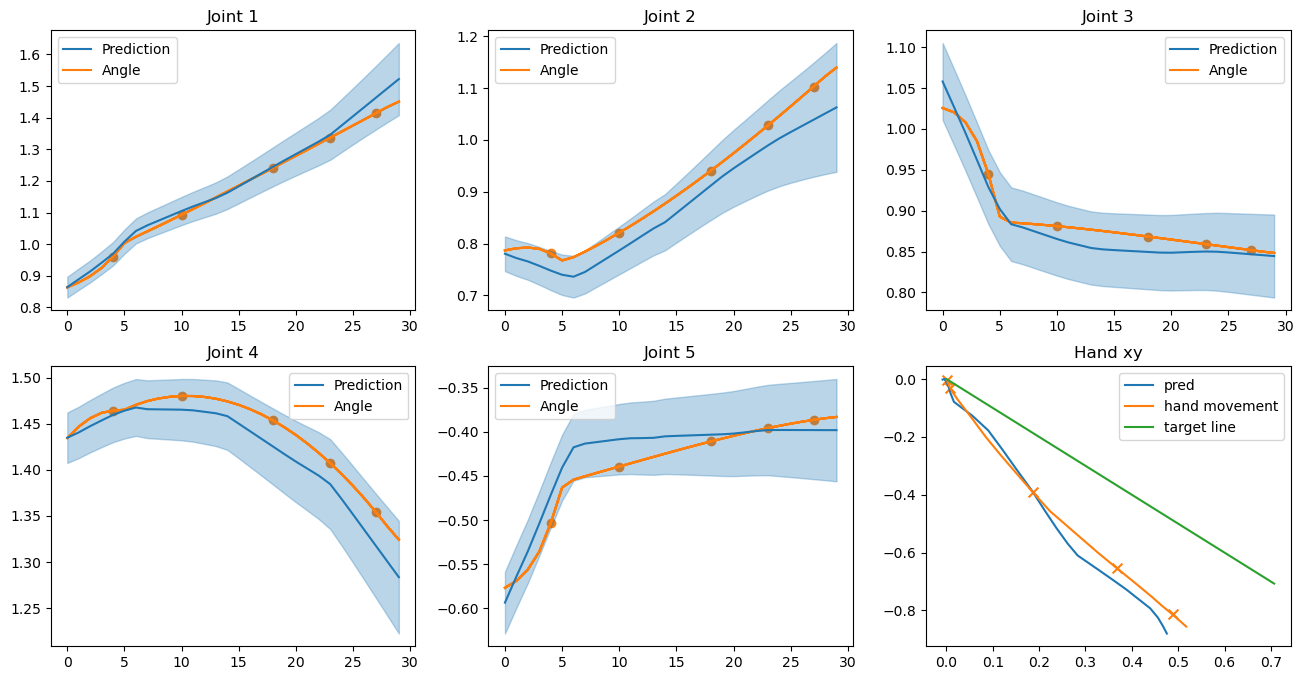

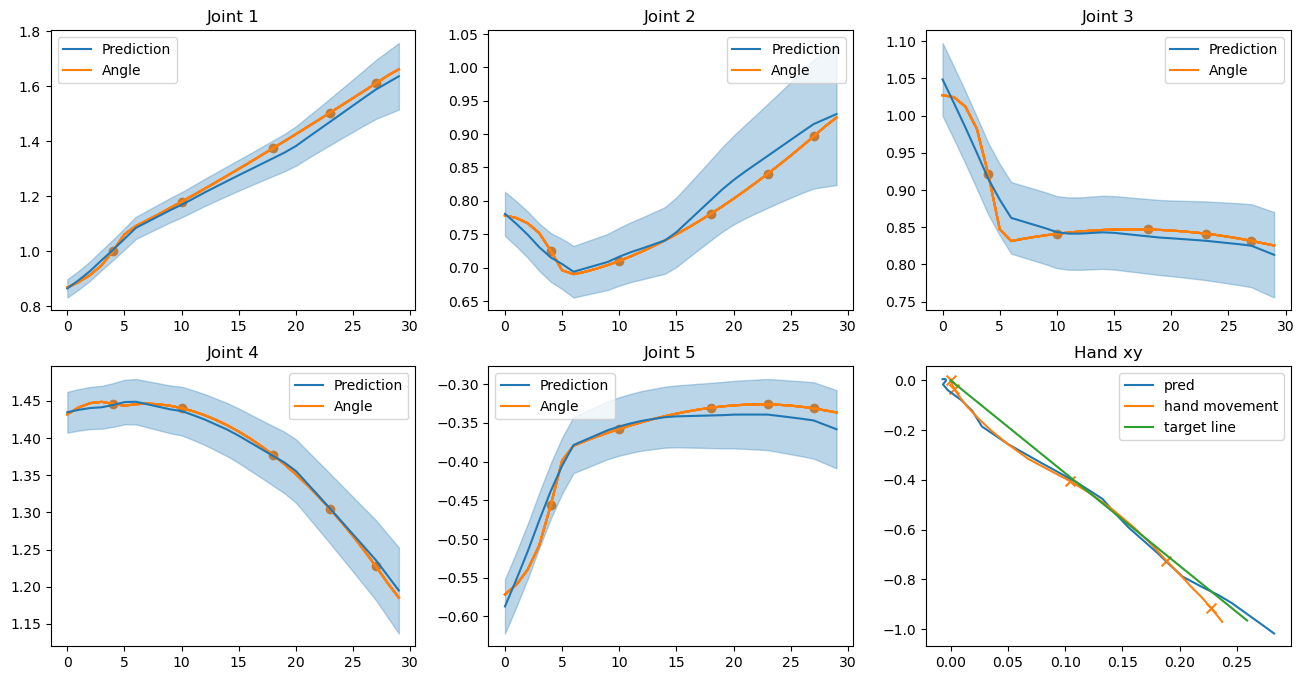

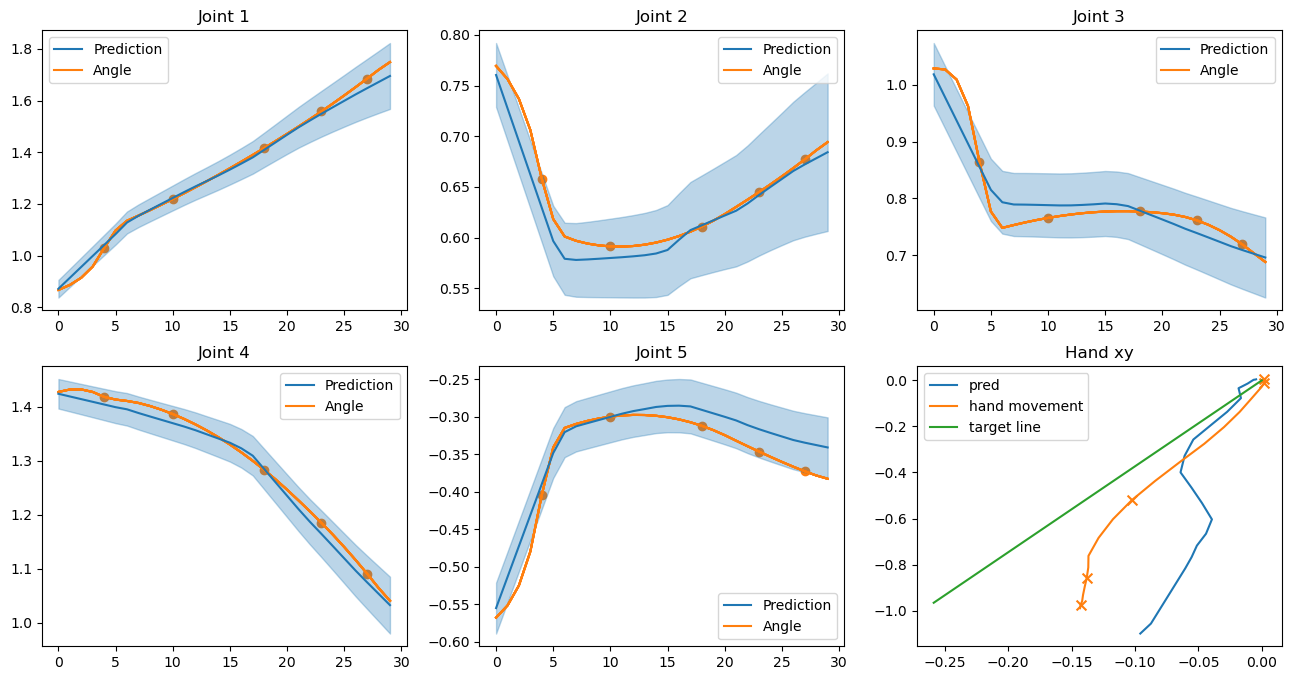

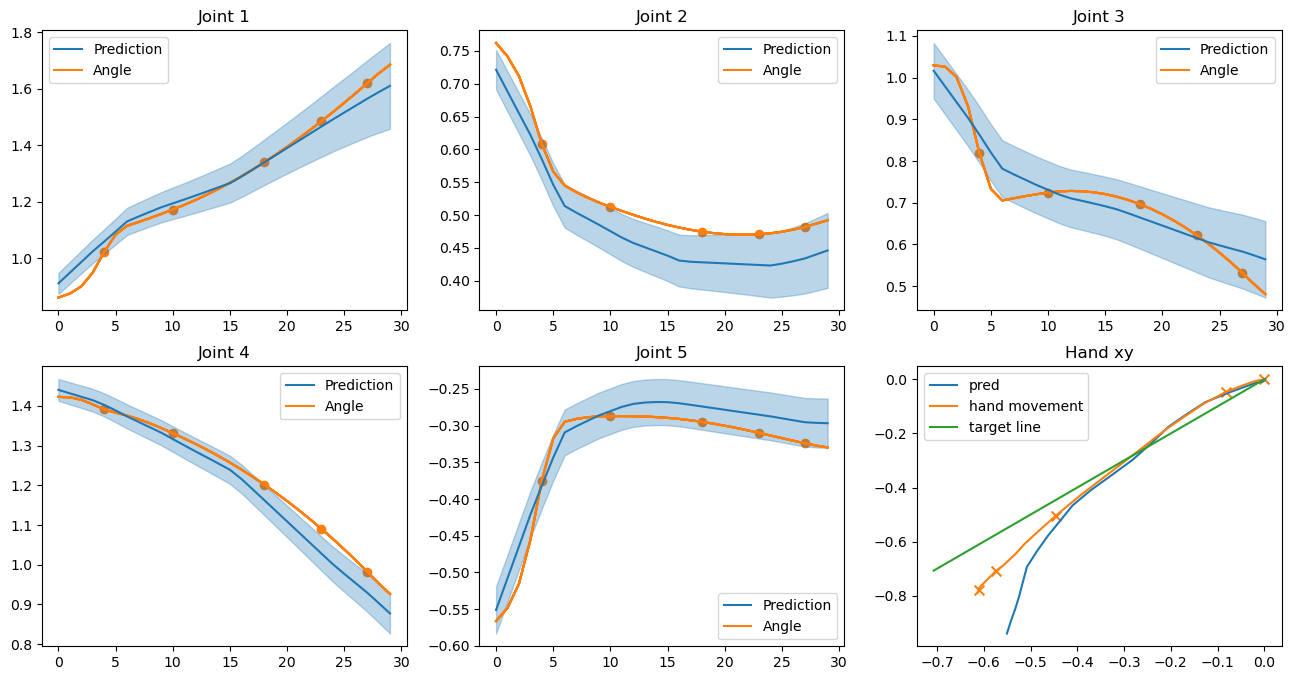

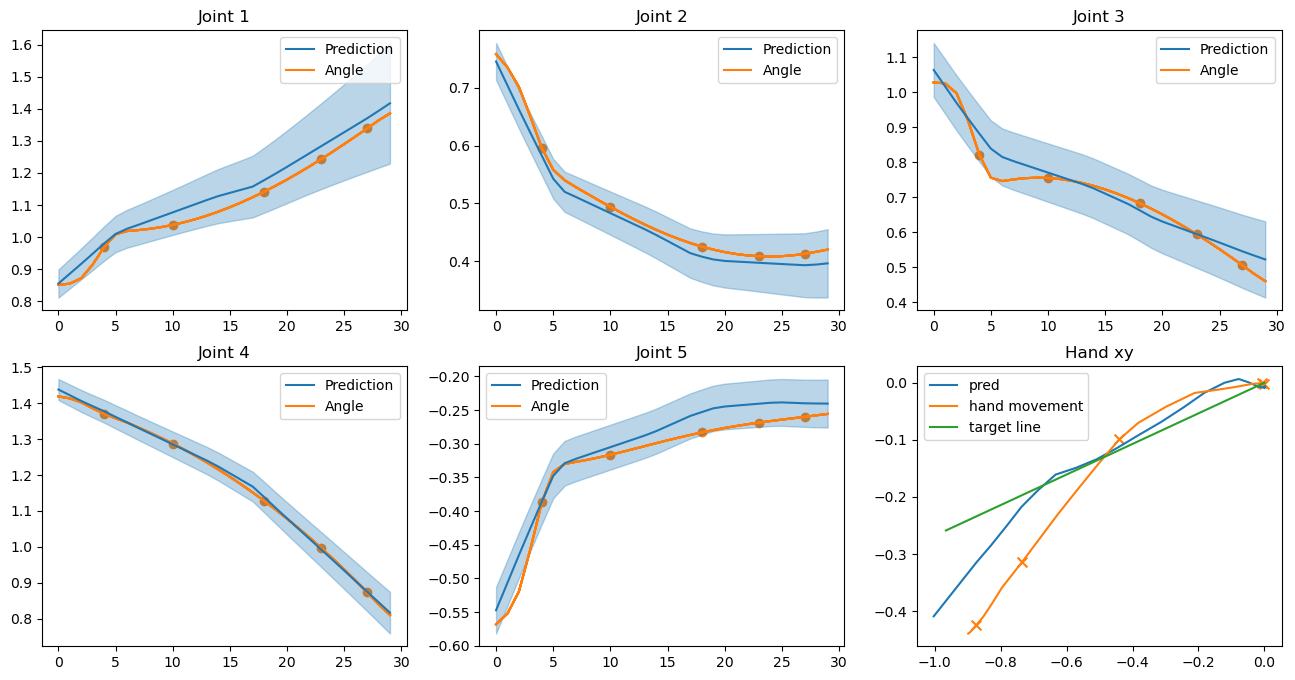

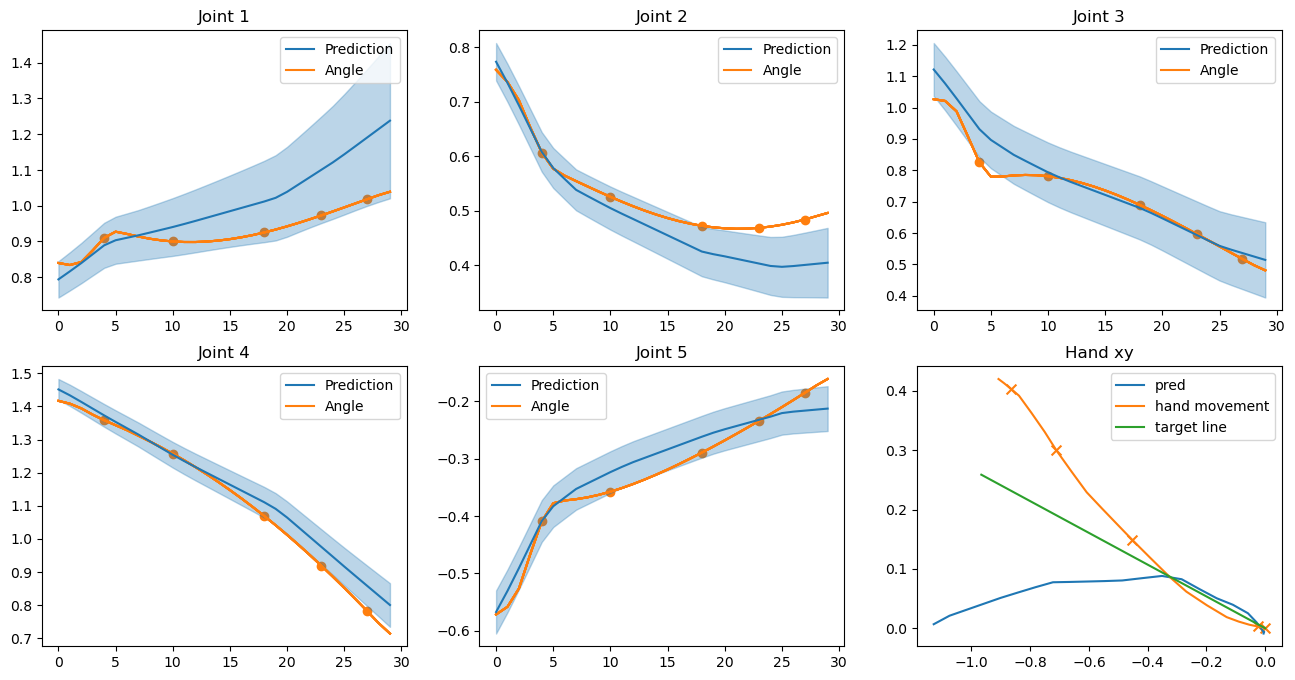

In [ ]:
valset.data = valset.joint
obs_indices = [4,10,18,23,27]
for act in range(7):
    obs_joints = valset.joint[act:act+1 , obs_indices, :]  # only the first timestep is observed
    obs_landmarks = valset.landmark[act:act+1 , obs_indices, :] 
    target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = valset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )

    fig, ax = plt.subplots(2, 3, figsize=(16, 8))
    for i in range(2):
        for j in range(3):
            idx = i * 3 + j + 1
            if idx == 1:
                l1 = "prediction"
                l2 = "data"
            else:
                l1,l2 = None, None
            
            for k in range(1,valset.data.shape[0]):
                if idx >= valset.data.shape[2]:
                    continue
                lab = None
                if k != 1:
                    lab = l2
                l2 = ax[i, j].plot(valset.data[act, :, idx], c="tab:orange", label = lab)
                # ax[i, j].legend()
            if idx == 0:
                continue
            if obs[0] != None:
                ax[i, j].scatter(obs_joints[0, :, 0] * 30, obs_joints[0, :, idx], c="tab:blue", marker="x", s=50)  # what the model observed
            ax[i, j].set_title(f"Joint {idx}")
            if idx - 1 >= mean.shape[-1]:
                continue  
            l1 = ax[i, j].plot(mean[0, :, idx-1], c="tab:blue",label = "prediction")
            ax[i,j].scatter(x = obs_indices, y = obs_joints[:,:,idx], c="tab:orange")
            ax[i, j].fill_between(range(mean.shape[1]),
                                mean[0, :, idx-1] - 2*std[0, :, idx-1],
                                mean[0, :, idx-1] + 2*std[0, :, idx-1],
                                alpha=0.3, color="tab:blue")
            ax[i, j].legend([l1[0], l2[0]], ["Prediction", "Angle"])
            # ax[i, j].set_ylim(-2, 2)
    i = 1
    j = 2
    ax[i, j].scatter(obs_landmarks[0,:, 1], obs_landmarks[0 ,:, 2], c="tab:orange", marker="x", s=50)  # what the model observed
    mean = land_1
    std = land_std
    ax[i, j].plot(mean[0, :,0] ,mean[0, :,1], c="tab:blue",label = "pred")
    ax[i, j].plot(valset.landmark[act, 3:, 1],valset.landmark[act, 3:, 2], c="tab:orange",label = "hand movement")
    ax[i, j].set_title(f"Hand xy")
    ax[i,j].plot([0, np.cos(act * np.pi/6 + np.pi/12)], [0, -np.sin(act * np.pi/6 + np.pi/12)], c ="tab:green", label = "target line")
    ax[i, j].legend()
    # ax[i, j].fill_between(range(mean.shape[1]),
    #                     mean[:,0] - 2*std[0, 1],
    #                     mean[:,1] + 2*std[0, :, idx-1],
    #                     alpha=0.3, color="b")



Executed robot position trajectories are compared to actual robot trajectories from validation set.

action0: actual angle = 18.23861959419457, pred_angle = 15.158536656738635


/tmp/ipykernel_15374/1411699826.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.arctan(torch.tensor(ds[2] / ds[1]))/torch.pi * 180


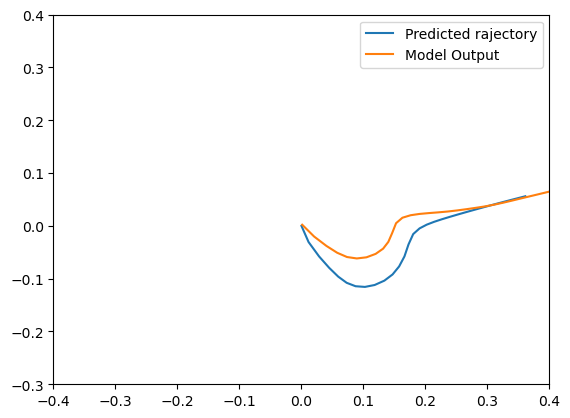

action1: actual angle = 50.797068539083135, pred_angle = 45.93332084403417


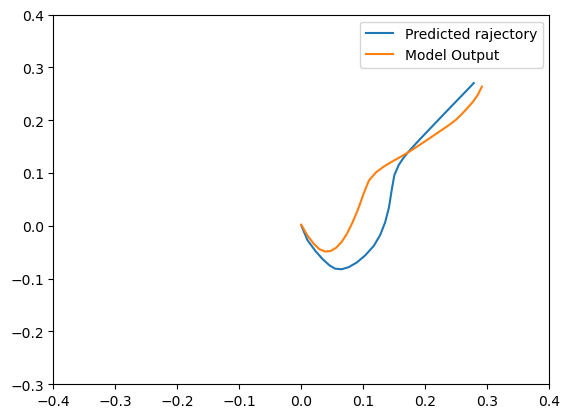

action2: actual angle = 78.25437819493527, pred_angle = 73.98512461149627


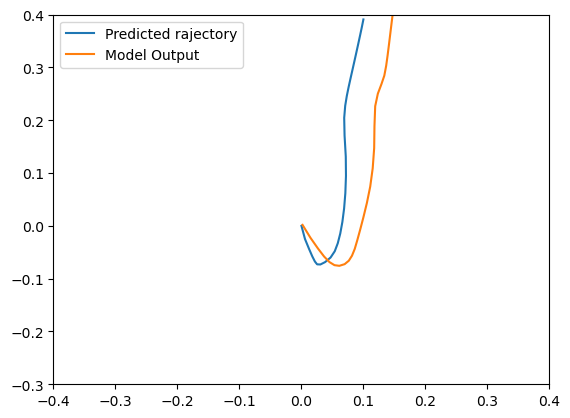

action3: actual angle = -74.61943009854448, pred_angle = -75.47691141126505


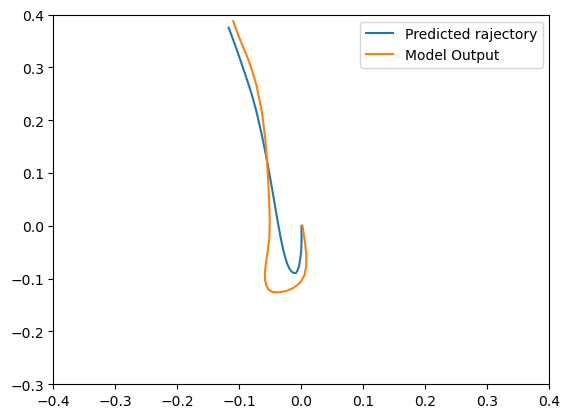

action4: actual angle = -44.39157337435134, pred_angle = -37.38365850090479


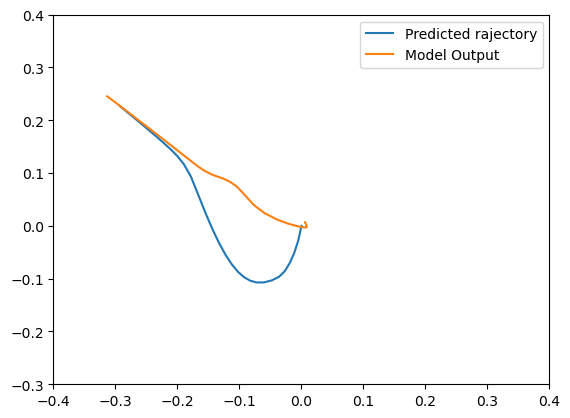

action5: actual angle = -11.502049571531867, pred_angle = -14.411228199402254


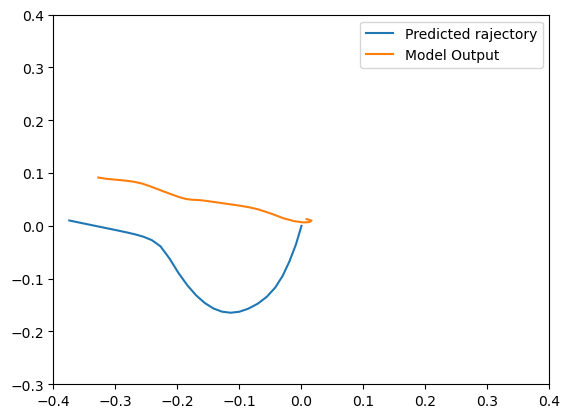

action6: actual angle = 22.0936842063573, pred_angle = 20.954129192600863


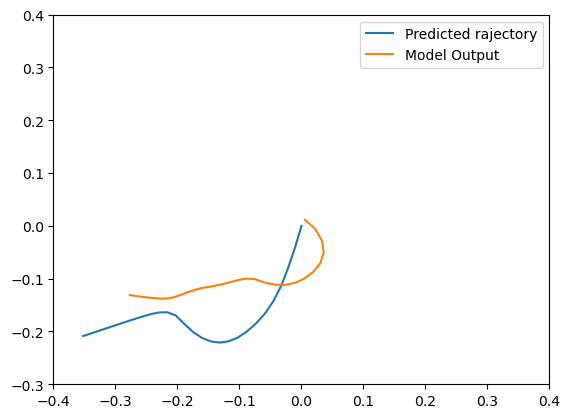

In [ ]:
for act in range(valset.joint.shape[0]):
    obs_joints = valset.joint[act:act+1 , [29], :]  # only the first timestep is observed
    obs_landmarks = valset.landmark[act:act+1 , [29], :] 
    target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = valset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )
    pred , pred_pos= get_angle(mean[0])
    org, org_pos = get_angle(valset.joint[act, :, 1:])
    print(f"action{act}: actual angle = {org}, pred_angle = {pred}")
    pred_pos = pred_pos - org_pos[0]
    org_pos = org_pos - org_pos[0]
    plt.plot(org_pos[:,1], org_pos[:,2], label = "Predicted rajectory")
    plt.plot(pred_pos[:,1], pred_pos[:,2], label = "Model Output")
    plt.xlim([-0.4, 0.4])
    plt.ylim([-0.3, 0.4])
    plt.legend()
    plt.show()

Executed robot position trajectories are compared to actual robot trajectories from training set.

action0: actual angle = -1.7727023003108375, pred_angle = 0.1459797823677136


/tmp/ipykernel_15374/1411699826.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.arctan(torch.tensor(ds[2] / ds[1]))/torch.pi * 180


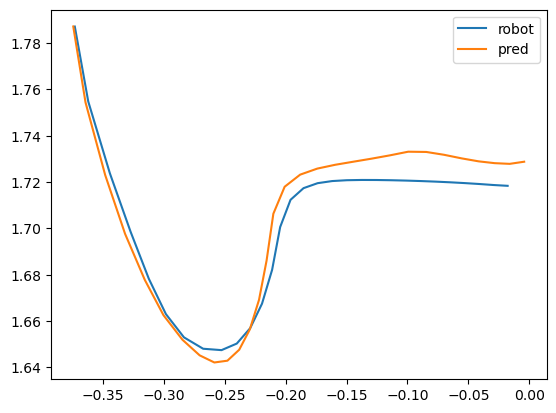

action1: actual angle = 35.74425257157528, pred_angle = 49.20228152894883


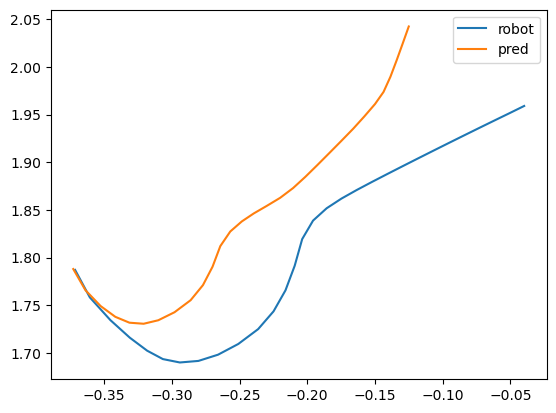

action2: actual angle = 64.90368747994266, pred_angle = 62.500261454492595


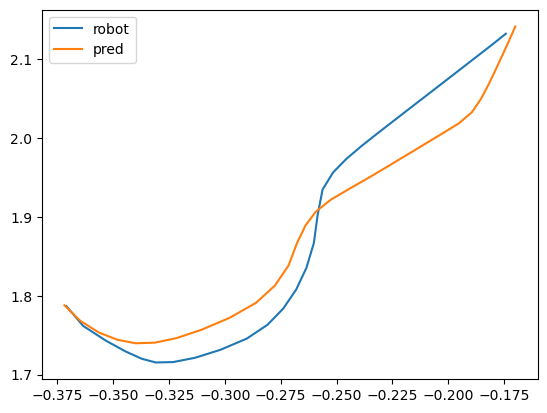

action3: actual angle = -88.076253336154, pred_angle = -87.79442655013102


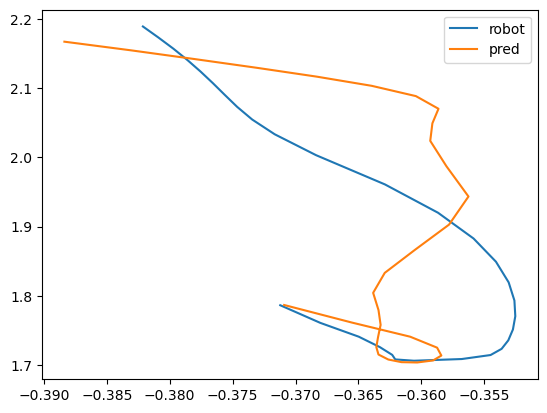

action4: actual angle = -60.12108588226884, pred_angle = -59.45855661232065


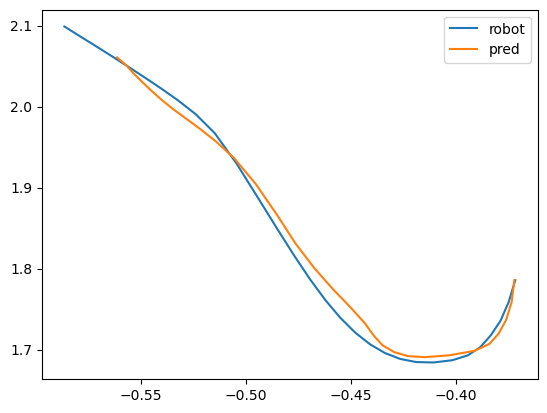

action5: actual angle = -28.23669537361802, pred_angle = -23.611710365393236


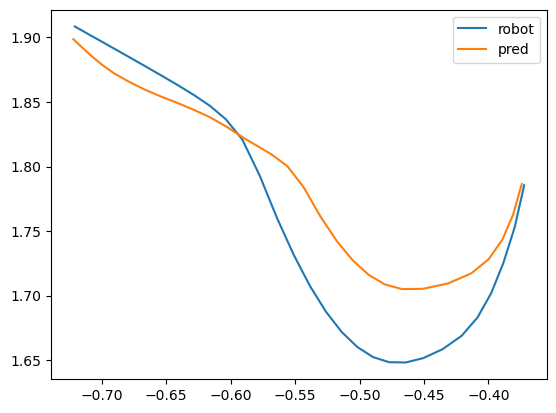

action6: actual angle = 5.639785940437033, pred_angle = -1.970702072819667


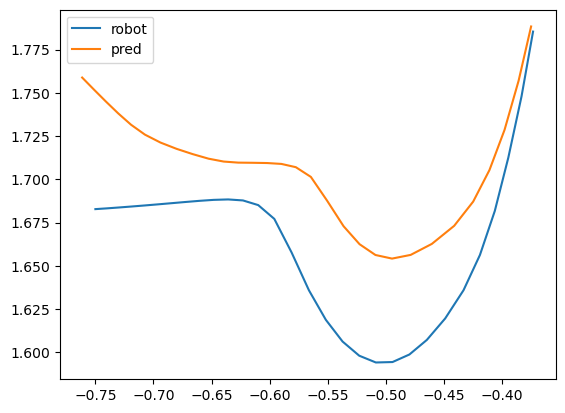

In [ ]:
for act in range(trainset.joint.shape[0]):
    obs_joints = trainset.joint[act:act+1 , [5,10,15,20,25], :]  # only the first timestep is observed
    obs_landmarks = trainset.landmark[act:act+1 , [5,10,15,20,25], :] 
    target_joints = trainset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = trainset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )
    pred , pred_pos= get_angle(mean[0])
    org, org_pos = get_angle(trainset.joint[act, :, 1:])
    print(f"action{act}: actual angle = {org}, pred_angle = {pred}")
    plt.plot(org_pos[:,1], org_pos[:,2], label = "robot")
    plt.plot(pred_pos[:,1], pred_pos[:,2], label = "pred")
    plt.legend()
    plt.show()